In [1]:
import sys
sys.path.append('./../')
from datetime import datetime
from src import proyecto_1
from src.pipelines import modeling
from src.pipelines import model_evaluation
from src.utils import utils

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
import sklearn.metrics as metrics

./../src/pipelines/feature_engineering.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)
/Users/yedam/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yedam/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yedam/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

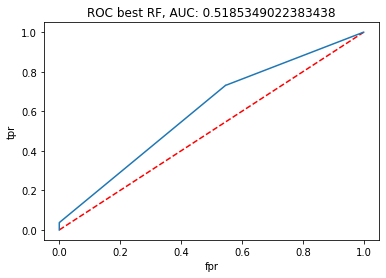

In [2]:
proyecto_1.main()

In [3]:
models = utils.load_df('output/model_loop.pkl')

In [232]:
models[0].best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, random_state=123)

In [233]:
models[1].best_estimator_

RandomForestClassifier(max_depth=1, min_samples_leaf=2, n_estimators=10,
                       oob_score=True, random_state=123)

In [ ]:
#model_evaluation.model_evaluation('./output/model_loop.pkl')

In [ ]:
#utils.load_df('./output/metricas_offline.pkl')

In [186]:
def load_model(path):
    model = utils.load_df('output/model_loop.pkl')
    return model

In [335]:
#Carga de datos de train y test
c5_train = utils.load_df('output/fe_df.pkl')
c5_test = utils.load_df('output/test.pkl')
#Preparacion de datos test
c5_test_ = c5_test.copy()
c5_train_ = c5_train.copy()
c5_train_ = c5_train_.drop('label',axis=1)
names=np.array(c5_test_.dia_semana.unique())
names=np.append(names,np.array(c5_test_.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_test_.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_test_.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))   
#Definicion de transformers
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
        ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
        ('mes', SimpleImputer(strategy="mean"), ['mes']),
        ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
        ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
col_trans.fit(c5_test_)
df_input_vars = col_trans.transform(c5_test_)
X = df_input_vars
y = c5_test.label.values.reshape(df_input_vars.shape[0],)
    
X_test = pd.DataFrame.sparse.from_spmatrix(X)
X_test.columns = names
X_test
selection_test = list(c5_train_.columns)
selection_test
X_test_ = X_test[selection_test]
prediction = (models[1].best_estimator_.predict_proba(X_test_)[:,1] >= 0.206002).astype(bool)
proba = models[1].best_estimator_.predict_proba(X_test_)

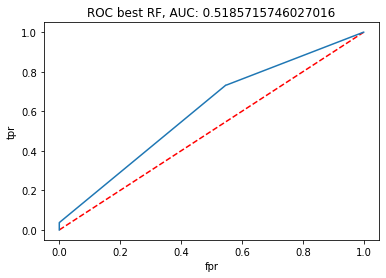

In [336]:
#%matplotlib inline
#Plot curva ROC
    
fpr, tpr, thresholds = roc_curve(y, proba[:,1], pos_label=1)
    
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y, prediction)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [337]:
#Plot matriz de confusion

(confusion_matrix(y, prediction))

array([[219869,    124],
       [ 54384,   2131]])

In [338]:
#Plot accuracy

accuracy_score(y, prediction)

0.8028700797083629

In [324]:
# Plot oprecision, recall, thresholds
    
precision, recall, thresholds_2 = precision_recall_curve(y, proba[:,1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)

In [325]:
#Reporte de metricas
    
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                        'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
        
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
        
    df = df_1.merge(df_2, on="threshold")
    return df
        
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.152070,0.204388,1.000000,0.339406,1.000000,1.000000,0.000000,0.000000
1,0.169352,0.204517,0.999894,0.339578,0.999894,0.999100,0.000900,0.000106
2,0.188721,0.255165,0.733168,0.378575,0.733168,0.549790,0.450210,0.266832
3,0.206002,0.255897,0.733080,0.379368,0.733080,0.547613,0.452387,0.266920
4,0.208477,0.945011,0.037707,0.072520,0.037707,0.000564,0.999436,0.962293
5,0.225758,0.945430,0.037707,0.072521,0.037707,0.000559,0.999441,0.962293
6,0.509561,1.000000,0.037070,0.071490,0.037070,0.000000,1.000000,0.962930
7,0.526842,1.000000,0.037052,0.071457,0.037052,0.000000,1.000000,0.962948


In [326]:
#Precision&recall @k
    
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)

In [327]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.recall_score(y_true, y_pred)

In [328]:
def get_top_k(y,y_scores,k):
    array=np.stack((y, y_scores), axis=-1)
    ordena_k = array[np.argsort(array[:, 1])[::-1]]
    k_porc = int(len(y_scores)*k)
    top = ordena_k[:k_porc]
    return top[:,[0]],top[:,[1]]

In [329]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
         ## get_top_k es una función que ordena los scores de
         ## mayor a menor y toma los k% primeros
         #top_k_y,top_k_proba = get_top_k(y_true,y_scores, k)
         #d['precision'] = precision_at_k(top_k_y,top_k_proba,k)
         #d['recall'] = recall_at_k(top_k_y,top_k_proba,k)
        d['precision'] = precision_at_k(y_true, y_scores,k)
        d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    #ax1.plot([k,k],[1,0], 'k--', c='red')
    
    plt.legend()
    
    c5 = utils.load_df('output/ingest_df.pkl')
    min_fecha = '01/01/2014'
    max_fecha = '12/10/2020'
    min_fecha = datetime.strptime(min_fecha, '%d/%m/%Y')
    max_fecha = datetime.strptime(max_fecha, '%d/%m/%Y')
    dias = max_fecha-min_fecha
    dias
    ambulancias = 20
    dias=2476
    acc = c5['dia_semana'].count()
    acc_x_dia = acc/dias
    k = ambulancias / acc_x_dia
    k
    
    plt.axvline(x=k)

    #if save_target is not None:
    #    plt.savefig(save_target)

    return pr_k

,k,precision,recall
0,0.01,0.255897,0.733080
1,0.02,0.255897,0.733080
2,0.03,0.255897,0.733080
3,0.04,0.255897,0.733080
4,0.05,0.255897,0.733080
...,...,...,...
94,0.95,0.204517,0.999894
95,0.96,0.204517,0.999894
96,0.97,0.204517,0.999894
97,0.98,0.204517,0.999894


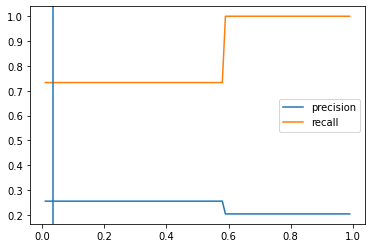

In [330]:
pr_k_curve(y, proba[:,1],0)

## Aequitas

In [261]:
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [262]:
c5_aeq = pd.DataFrame({'score':prediction, 'label_value': y, 'delegacion': c5_test['delegacion_inicio']})

In [263]:
c5_aeq['delegacion'] = c5_aeq['delegacion'].astype(str)

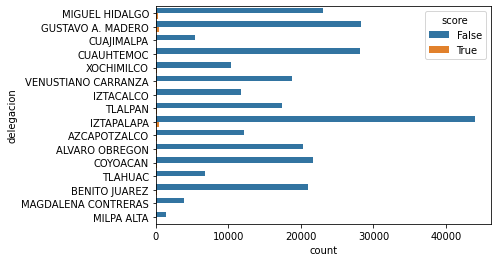

In [264]:
by_delegacion = sns.countplot(y="delegacion", hue="score", data=c5_aeq)

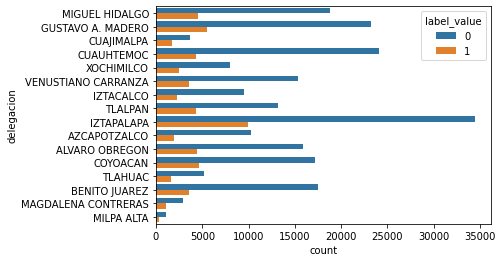

In [265]:
by_delegacion = sns.countplot(y="delegacion", hue="label_value", data=c5_aeq)

In [266]:
g = Group()
xtab, attrbs = g.get_crosstabs(c5_aeq)

model_id, score_thresholds 0 {'rank_abs': [2255]}


In [267]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,2255,delegacion,ALVARO OBREGON,0.038229,0.999686,0.212833,0.028409,0.000314,...,0.008632,5,4302,15911,171,4473,15916,20389,276508,0.219383
1,0,binary 0/1,2255,delegacion,AZCAPOTZALCO,0.040000,0.999610,0.155960,0.048193,0.000390,...,0.006781,4,1896,10261,79,1975,10265,12240,276508,0.161356
2,0,binary 0/1,2255,delegacion,BENITO JUAREZ,0.021993,0.999771,0.167389,0.048193,0.000229,...,0.003939,4,3513,17474,79,3592,17478,21070,276508,0.170479
3,0,binary 0/1,2255,delegacion,COYOACAN,0.026310,0.999418,0.209625,0.075188,0.000582,...,0.006088,10,4552,17163,123,4675,17173,21848,276508,0.213978
4,0,binary 0/1,2255,delegacion,CUAJIMALPA,0.014376,0.998903,0.320015,0.137931,0.001097,...,0.005385,4,1714,3642,25,1739,3646,5385,276508,0.322934
5,0,binary 0/1,2255,delegacion,CUAUHTEMOC,0.039348,0.999543,0.146509,0.061111,0.000457,...,0.006351,11,4126,24036,169,4295,24047,28342,276508,0.151542
6,0,binary 0/1,2255,delegacion,GUSTAVO A. MADERO,0.077617,0.999268,0.180419,0.038031,0.000732,...,0.015537,17,5110,23213,430,5540,23230,28770,276508,0.192562
7,0,binary 0/1,2255,delegacion,IZTACALCO,0.019139,0.999475,0.191638,0.102041,0.000525,...,0.004147,5,2255,9512,44,2299,9517,11816,276508,0.194567
8,0,binary 0/1,2255,delegacion,IZTAPALAPA,0.037018,0.999245,0.217697,0.065990,0.000755,...,0.008880,26,9573,34401,368,9941,34427,44368,276508,0.224058
9,0,binary 0/1,2255,delegacion,MAGDALENA CONTRERAS,0.013048,0.999652,0.269534,0.066667,0.000348,...,0.003803,1,1059,2870,14,1073,2871,3944,276508,0.272059


In [268]:
absolute_metrics = g.list_absolute_metrics(xtab)

Frecuencias

In [269]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,2255,delegacion,ALVARO OBREGON,176,20213,5,4302,15911,171,4473,15916,20389,276508
1,0,binary 0/1,2255,delegacion,AZCAPOTZALCO,83,12157,4,1896,10261,79,1975,10265,12240,276508
2,0,binary 0/1,2255,delegacion,BENITO JUAREZ,83,20987,4,3513,17474,79,3592,17478,21070,276508
3,0,binary 0/1,2255,delegacion,COYOACAN,133,21715,10,4552,17163,123,4675,17173,21848,276508
4,0,binary 0/1,2255,delegacion,CUAJIMALPA,29,5356,4,1714,3642,25,1739,3646,5385,276508
5,0,binary 0/1,2255,delegacion,CUAUHTEMOC,180,28162,11,4126,24036,169,4295,24047,28342,276508
6,0,binary 0/1,2255,delegacion,GUSTAVO A. MADERO,447,28323,17,5110,23213,430,5540,23230,28770,276508
7,0,binary 0/1,2255,delegacion,IZTACALCO,49,11767,5,2255,9512,44,2299,9517,11816,276508
8,0,binary 0/1,2255,delegacion,IZTAPALAPA,394,43974,26,9573,34401,368,9941,34427,44368,276508
9,0,binary 0/1,2255,delegacion,MAGDALENA CONTRERAS,15,3929,1,1059,2870,14,1073,2871,3944,276508


Absolutos

In [299]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(5)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,ALVARO OBREGON,0.03823,0.99969,0.21283,0.02841,0.00031,0.96177,0.78717,0.97159,0.07805,0.00863,0.21938
1,delegacion,AZCAPOTZALCO,0.04000,0.99961,0.15596,0.04819,0.00039,0.96000,0.84404,0.95181,0.03681,0.00678,0.16136
2,delegacion,BENITO JUAREZ,0.02199,0.99977,0.16739,0.04819,0.00023,0.97801,0.83261,0.95181,0.03681,0.00394,0.17048
3,delegacion,COYOACAN,0.02631,0.99942,0.20962,0.07519,0.00058,0.97369,0.79038,0.92481,0.05898,0.00609,0.21398
4,delegacion,CUAJIMALPA,0.01438,0.99890,0.32001,0.13793,0.00110,0.98562,0.67999,0.86207,0.01286,0.00539,0.32293
5,delegacion,CUAUHTEMOC,0.03935,0.99954,0.14651,0.06111,0.00046,0.96065,0.85349,0.93889,0.07982,0.00635,0.15154
6,delegacion,GUSTAVO A. MADERO,0.07762,0.99927,0.18042,0.03803,0.00073,0.92238,0.81958,0.96197,0.19823,0.01554,0.19256
7,delegacion,IZTACALCO,0.01914,0.99947,0.19164,0.10204,0.00053,0.98086,0.80836,0.89796,0.02173,0.00415,0.19457
8,delegacion,IZTAPALAPA,0.03702,0.99924,0.21770,0.06599,0.00076,0.96298,0.78230,0.93401,0.17472,0.00888,0.22406
9,delegacion,MAGDALENA CONTRERAS,0.01305,0.99965,0.26953,0.06667,0.00035,0.98695,0.73047,0.93333,0.00665,0.00380,0.27206


In [296]:
xtab.fpr.median()

0.0005243309405785577

Visualización de sesgo en los grupos

In [271]:
aeq = Plot()

In [272]:
#fdr = aeq.plot_group_metric(xtab, 'fdr')

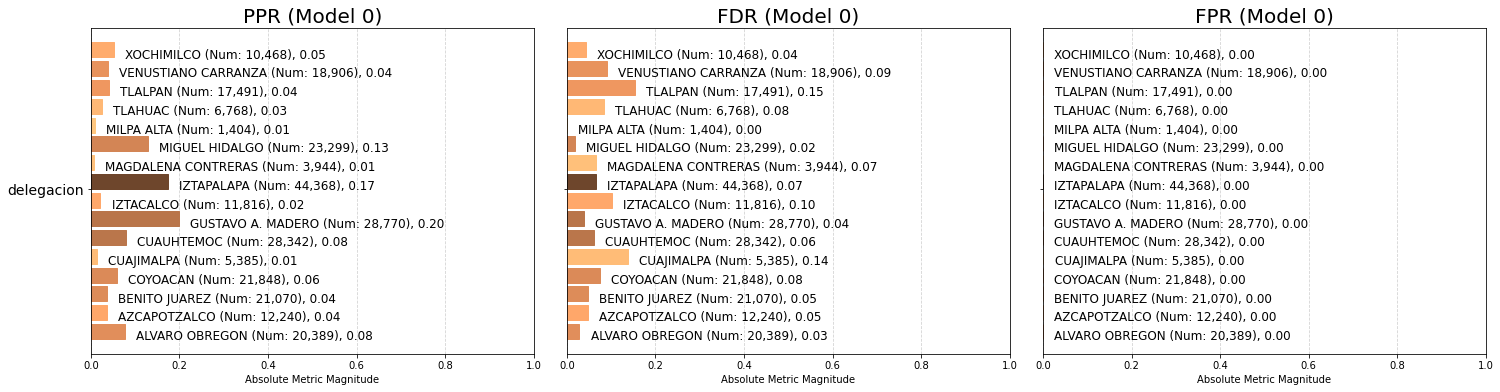

<Figure size 432x288 with 0 Axes>

In [273]:
p = aeq.plot_group_metric_all(xtab, metrics=['ppr','fdr','fpr'])

### Bias

In [300]:
bias = Bias()

In [301]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=c5_aeq, 
                                        ref_groups_dict={'delegacion':'VENUSTIANO CARRANZA'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


In [302]:
#Cual es conteo de frecuencas y cual absoluto

# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,1.98,1.83,1.07,0.32,1.13,0.60,0.98,1.71,1.0,0.97
1,delegacion,AZCAPOTZALCO,0.93,1.44,1.05,0.54,0.83,0.74,0.98,1.79,1.0,1.04
2,delegacion,BENITO JUAREZ,0.93,0.84,1.05,0.54,0.89,0.44,1.00,0.98,1.0,1.03
3,delegacion,COYOACAN,1.49,1.29,1.02,0.84,1.12,1.11,1.00,1.18,1.0,0.97
4,delegacion,CUAJIMALPA,0.33,1.14,0.95,1.53,1.70,2.10,1.01,0.64,1.0,0.84
5,delegacion,CUAUHTEMOC,2.02,1.35,1.03,0.68,0.78,0.87,0.98,1.76,1.0,1.05
6,delegacion,GUSTAVO A. MADERO,5.02,3.30,1.06,0.42,0.96,1.40,0.94,3.47,1.0,1.01
7,delegacion,IZTACALCO,0.55,0.88,0.99,1.14,1.02,1.00,1.00,0.85,1.0,1.00
8,delegacion,IZTAPALAPA,4.43,1.89,1.03,0.73,1.16,1.44,0.99,1.65,1.0,0.96
9,delegacion,MAGDALENA CONTRERAS,0.17,0.81,1.03,0.74,1.43,0.67,1.01,0.58,1.0,0.90


In [303]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=c5_aeq)

get_disparity_major_group()


In [304]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,0.45,0.97,1.04,0.43,0.98,0.42,1.00,1.03,1.0,1.01
1,delegacion,AZCAPOTZALCO,0.21,0.76,1.02,0.73,0.72,0.52,1.00,1.08,1.0,1.08
2,delegacion,BENITO JUAREZ,0.21,0.44,1.02,0.73,0.77,0.30,1.02,0.59,1.0,1.06
3,delegacion,COYOACAN,0.34,0.69,0.99,1.14,0.96,0.77,1.01,0.71,1.0,1.01
4,delegacion,CUAJIMALPA,0.07,0.61,0.92,2.09,1.47,1.45,1.02,0.39,1.0,0.87
5,delegacion,CUAUHTEMOC,0.46,0.72,1.01,0.93,0.67,0.61,1.00,1.06,1.0,1.09
6,delegacion,GUSTAVO A. MADERO,1.13,1.75,1.03,0.58,0.83,0.97,0.96,2.10,1.0,1.05
7,delegacion,IZTACALCO,0.12,0.47,0.96,1.55,0.88,0.70,1.02,0.52,1.0,1.03
8,delegacion,IZTAPALAPA,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00
9,delegacion,MAGDALENA CONTRERAS,0.04,0.43,1.00,1.01,1.24,0.46,1.02,0.35,1.0,0.93


In [305]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=c5_aeq)

get_disparity_min_metric()


In [306]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,ALVARO OBREGON,11.73,2.27,1.15,10.0,1.45,10.0,1.04,2.93,1.0,1.16
1,delegacion,AZCAPOTZALCO,5.53,1.78,1.12,10.0,1.06,10.0,1.04,3.07,1.0,1.24
2,delegacion,BENITO JUAREZ,5.53,1.04,1.12,10.0,1.14,10.0,1.06,1.69,1.0,1.22
3,delegacion,COYOACAN,8.87,1.60,1.09,10.0,1.43,10.0,1.06,2.02,1.0,1.16
4,delegacion,CUAJIMALPA,1.93,1.42,1.02,10.0,2.18,10.0,1.07,1.10,1.0,1.00
5,delegacion,CUAUHTEMOC,12.00,1.67,1.11,10.0,1.00,10.0,1.04,3.02,1.0,1.26
6,delegacion,GUSTAVO A. MADERO,29.80,4.09,1.14,10.0,1.23,10.0,1.00,5.95,1.0,1.21
7,delegacion,IZTACALCO,3.27,1.09,1.06,10.0,1.31,10.0,1.06,1.47,1.0,1.19
8,delegacion,IZTAPALAPA,26.27,2.33,1.10,10.0,1.49,10.0,1.04,2.84,1.0,1.15
9,delegacion,MAGDALENA CONTRERAS,1.00,1.00,1.10,10.0,1.84,10.0,1.07,1.00,1.0,1.07


Visualización de disparidades

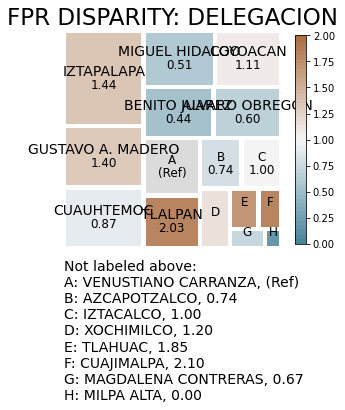

In [339]:
fpr_disparity = aeq.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='delegacion', significance_alpha=0.05)

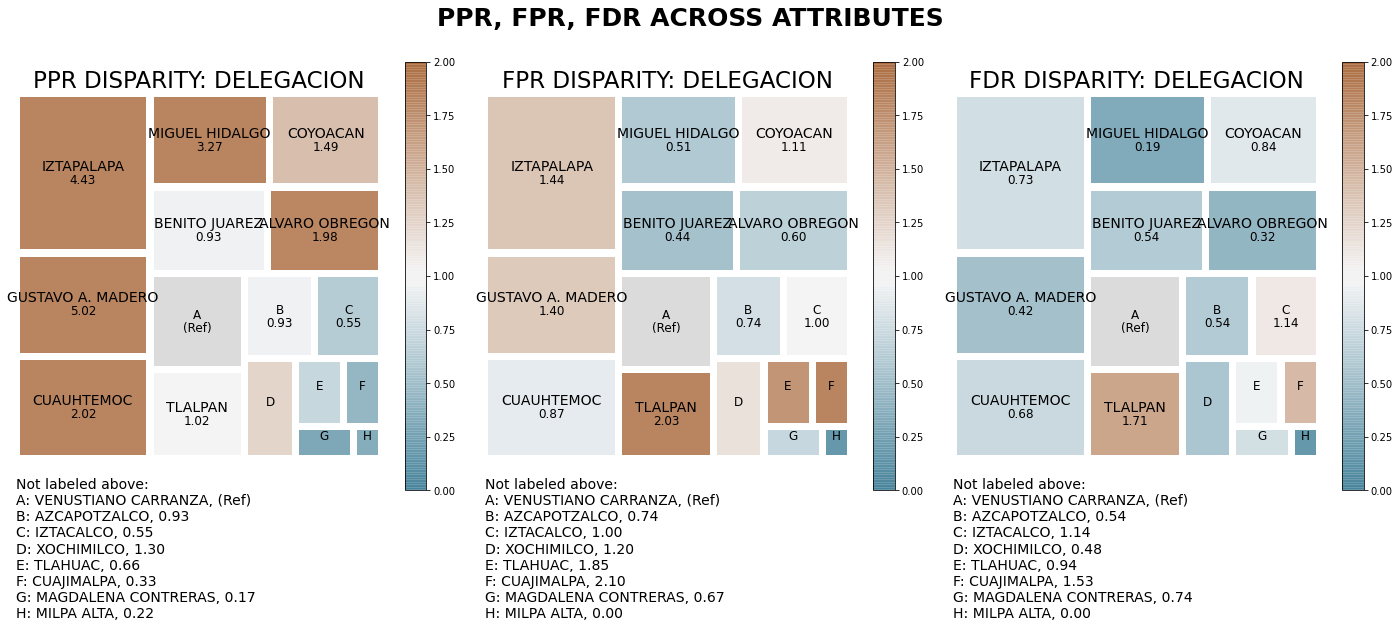

In [341]:
p = aeq.plot_disparity_all(bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

### Fairness

In [309]:
fair = Fairness()

In [310]:
fdf = fair.get_group_value_fairness(bdf)

In [311]:
parity_determinations = fair.list_parities(fdf)

In [312]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

#Cual es conteo de frecuencas y cual absoluto

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Precision Parity,Statistical Parity,TypeII Parity,TypeI Parity,Impact Parity,FOR Parity,FNR Parity,Unsupervised Fairness,Equalized Odds,TNR Parity
0,delegacion,ALVARO OBREGON,0.04,1.0,0.21,0.03,0.0,0.96,0.79,0.97,...,True,False,True,False,False,True,True,False,False,True
1,delegacion,AZCAPOTZALCO,0.04,1.0,0.16,0.05,0.0,0.96,0.84,0.95,...,True,True,True,False,False,True,True,False,False,True
2,delegacion,BENITO JUAREZ,0.02,1.0,0.17,0.05,0.0,0.98,0.83,0.95,...,True,True,True,False,True,True,True,True,False,True
3,delegacion,COYOACAN,0.03,1.0,0.21,0.08,0.0,0.97,0.79,0.92,...,True,False,True,True,False,True,True,False,True,True
4,delegacion,CUAJIMALPA,0.01,1.0,0.32,0.14,0.0,0.99,0.68,0.86,...,True,False,False,False,True,False,True,False,False,True
5,delegacion,CUAUHTEMOC,0.04,1.0,0.15,0.06,0.0,0.96,0.85,0.94,...,True,False,False,False,False,False,True,False,False,True
6,delegacion,GUSTAVO A. MADERO,0.08,1.0,0.18,0.04,0.0,0.92,0.82,0.96,...,True,False,True,False,False,True,True,False,False,True
7,delegacion,IZTACALCO,0.02,1.0,0.19,0.10,0.0,0.98,0.81,0.90,...,True,False,True,True,True,True,True,False,True,True
8,delegacion,IZTAPALAPA,0.04,1.0,0.22,0.07,0.0,0.96,0.78,0.93,...,True,False,True,False,False,True,True,False,False,True
9,delegacion,MAGDALENA CONTRERAS,0.01,1.0,0.27,0.07,0.0,0.99,0.73,0.93,...,True,False,False,False,True,False,True,False,False,True


In [313]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,False,False,False,False,True,False,True,True,True,False,False,False,False,False


In [314]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,2255,delegacion,ALVARO OBREGON,0.038229,0.999686,0.212833,0.028409,0.000314,...,True,False,True,True,True,False,True,False,False,False
1,0,binary 0/1,2255,delegacion,AZCAPOTZALCO,0.040000,0.999610,0.155960,0.048193,0.000390,...,True,False,True,True,True,False,True,False,False,False
2,0,binary 0/1,2255,delegacion,BENITO JUAREZ,0.021993,0.999771,0.167389,0.048193,0.000229,...,True,True,True,True,True,False,True,False,True,False
3,0,binary 0/1,2255,delegacion,COYOACAN,0.026310,0.999418,0.209625,0.075188,0.000582,...,True,True,True,True,True,True,True,True,False,True
4,0,binary 0/1,2255,delegacion,CUAJIMALPA,0.014376,0.998903,0.320015,0.137931,0.001097,...,True,False,True,True,True,False,False,False,False,False
5,0,binary 0/1,2255,delegacion,CUAUHTEMOC,0.039348,0.999543,0.146509,0.061111,0.000457,...,True,False,True,True,True,False,False,False,False,False
6,0,binary 0/1,2255,delegacion,GUSTAVO A. MADERO,0.077617,0.999268,0.180419,0.038031,0.000732,...,True,False,True,True,True,False,True,False,False,False
7,0,binary 0/1,2255,delegacion,IZTACALCO,0.019139,0.999475,0.191638,0.102041,0.000525,...,True,True,True,True,True,True,True,True,False,True
8,0,binary 0/1,2255,delegacion,IZTAPALAPA,0.037018,0.999245,0.217697,0.065990,0.000755,...,True,False,True,True,True,False,True,False,False,False
9,0,binary 0/1,2255,delegacion,MAGDALENA CONTRERAS,0.013048,0.999652,0.269534,0.066667,0.000348,...,True,False,True,True,True,False,False,False,False,False


In [315]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

Visualización de equidad

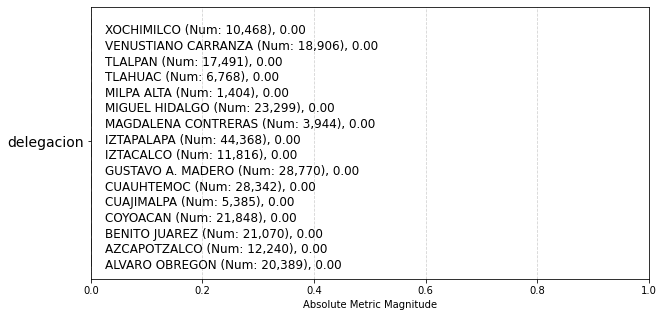

In [316]:
z = aeq.plot_fairness_group(fdf, group_metric='fpr')

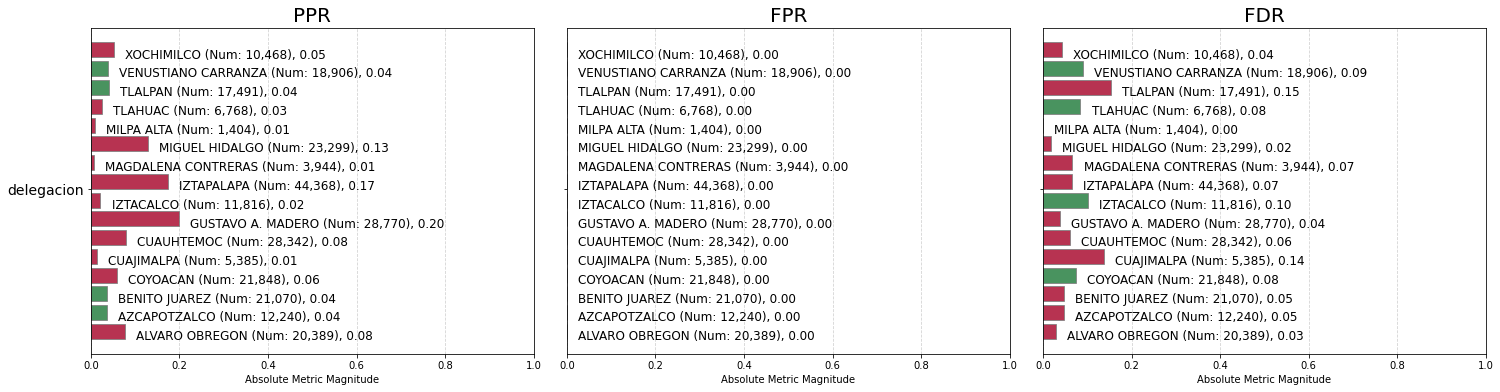

<Figure size 432x288 with 0 Axes>

In [317]:
z = aeq.plot_fairness_group_all(fdf, metrics=['ppr','fpr','fdr'])

In [318]:
#m = aeq.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='delegacion')

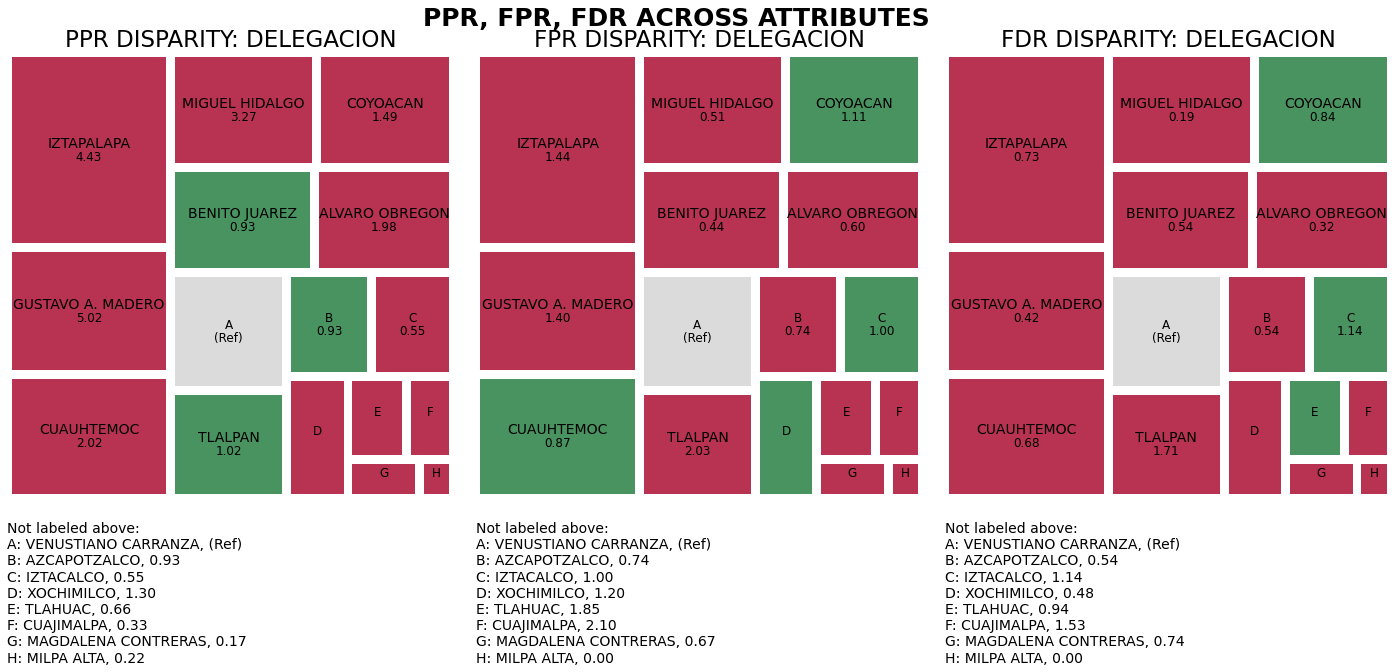

In [319]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])